<a href="https://colab.research.google.com/github/lucianoh34/RedesNeurais/blob/main/Forecasting_Apple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance tensorflow scikit-learn

[*********************100%%**********************]  1 of 1 completed


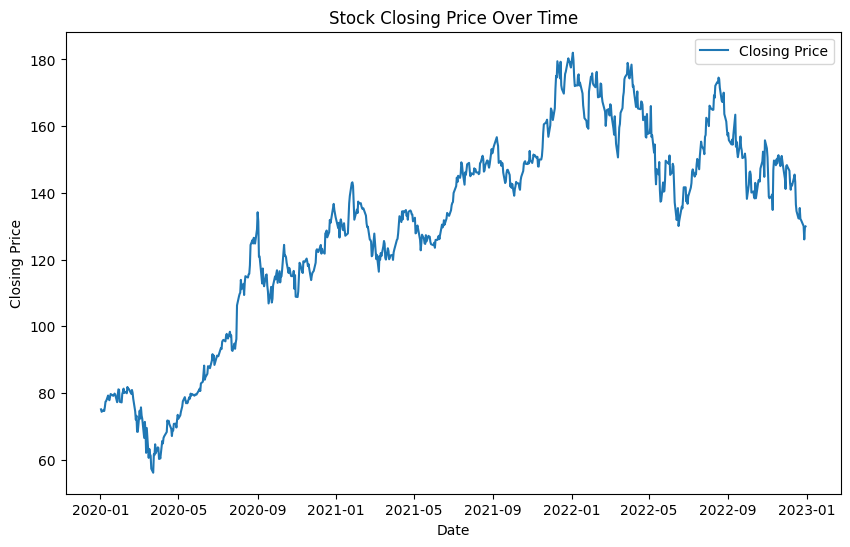

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow import keras
from tensorflow.keras import layers

# Coletando dados de ações da Yahoo Finance usando yfinance
start_date = '2020-01-01'
end_date = '2023-01-01'
ticker = 'AAPL'  # Apple Inc.

df = yf.download(ticker, start=start_date, end=end_date)

# Visualização dos dados de fechamento ao longo do tempo
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], label='Closing Price')
plt.title('Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()



In [3]:
# Preparação dos dados para modelagem de séries temporais
sequence_length = 30  # comprimento da sequência para previsão
close_prices = df['Close'].values
X, y = [], []
for i in range(len(close_prices) - sequence_length):
    X.append(close_prices[i:i+sequence_length])
    y.append(close_prices[i+sequence_length])
X = np.array(X)
y = np.array(y)

# Dividindo os dados em conjunto de treino e teste
#split_index = int(0.8 * len(X))
#X_train, X_test = X[:split_index], X[split_index:]
#y_train, y_test = y[:split_index], y[split_index:]

# Dividindo os dados em conjunto de treino, validação e teste
train_size = int(0.6 * len(X))
val_size = int(0.2 * len(X))
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]


# Normalização dos dados
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

# Normalização dos dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [4]:
# Modelo Naive (Baseline)
y_pred_naive = X_test[:, -1]
mape_naive = mean_absolute_percentage_error(y_test, y_pred_naive)
print(f"MAPE Naïve Baseline: {mape_naive:.2f}")

MAPE Naïve Baseline: 0.02


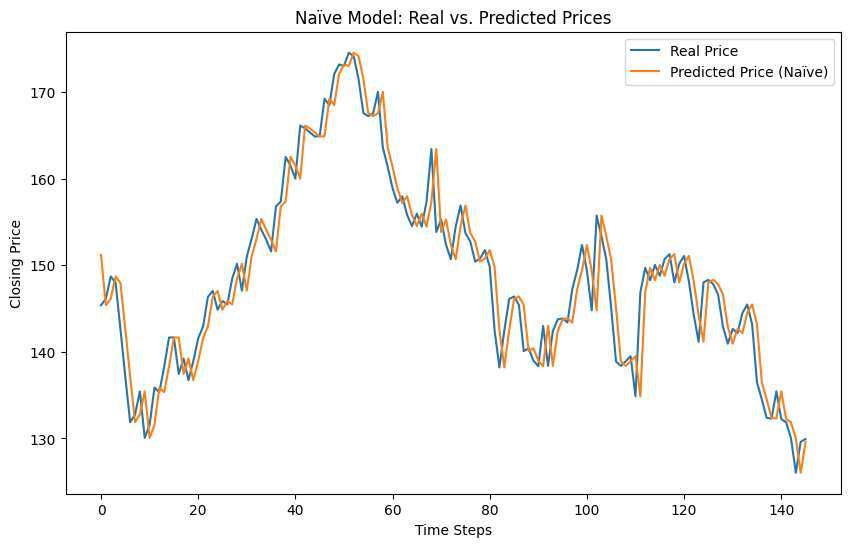

In [5]:
# Gráfico das previsões do modelo Naive vs. Valores Reais
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Real Price')
plt.plot(range(len(y_pred_naive)), y_pred_naive, label='Predicted Price (Naive)')
plt.title('Naive Model: Real vs. Predicted Prices')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [6]:
# Modelo de Convolução 1D
inputs = keras.Input(shape=(sequence_length, 1))
x = layers.Conv1D(32, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(64, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(1)(x)
model_conv1d = keras.Model(inputs, outputs)

model_conv1d.compile(optimizer='adam', loss='mse')

# Treinamento do modelo de Convolução 1D
history_conv1d = model_conv1d.fit(X_train_scaled.reshape(-1, sequence_length, 1), y_train, epochs=50, batch_size=32, validation_split=0.1)

# Avaliação do modelo de Convolução 1D usando MAPE
y_pred_conv1d = model_conv1d.predict(X_test_scaled.reshape(-1, sequence_length, 1))
mape_conv1d = mean_absolute_percentage_error(y_test, y_pred_conv1d)
print(f"MAPE 1D Convolutional: {mape_conv1d:.2f}")

Epoch 1/50
13/13 [==============================] - 1s 24ms/step - loss: 13370.9492 - val_loss: 21361.0234
Epoch 2/50
13/13 [==============================] - 0s 7ms/step - loss: 13196.8682 - val_loss: 20915.0078
Epoch 3/50
13/13 [==============================] - 0s 6ms/step - loss: 12903.2637 - val_loss: 20129.6074
Epoch 4/50
13/13 [==============================] - 0s 8ms/step - loss: 12404.6328 - val_loss: 18818.5000
Epoch 5/50
13/13 [==============================] - 0s 7ms/step - loss: 11608.1875 - val_loss: 16880.4668
Epoch 6/50
13/13 [==============================] - 0s 7ms/step - loss: 10482.3389 - val_loss: 14261.9727
Epoch 7/50
13/13 [==============================] - 0s 5ms/step - loss: 9042.8877 - val_loss: 11059.7520
Epoch 8/50
13/13 [==============================] - 0s 6ms/step - loss: 7403.6440 - val_loss: 7567.4536
Epoch 9/50
13/13 [==============================] - 0s 7ms/step - loss: 5727.4321 - val_loss: 4171.4526
Epoch 10/50
13/13 [==============================]

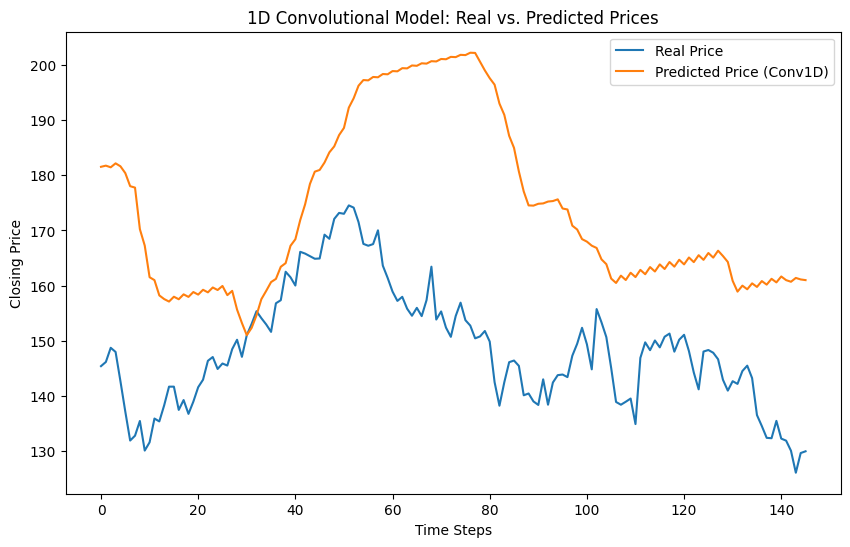

In [7]:
# Gráfico das previsões do modelo de Convolução 1D vs. Valores Reais
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Real Price')
plt.plot(range(len(y_pred_conv1d)), y_pred_conv1d, label='Predicted Price (Conv1D)')
plt.title('1D Convolutional Model: Real vs. Predicted Prices')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [8]:
# Modelo Densely Connected
inputs = keras.Input(shape=(sequence_length,))
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(1)(x)
model_dense = keras.Model(inputs, outputs)

model_dense.compile(optimizer='adam', loss='mse')

# Treinamento do modelo Densely Connected
history_dense = model_dense.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Avaliação do modelo Densely Connected usando MAPE
y_pred_dense = model_dense.predict(X_test_scaled)
mape_dense = mean_absolute_percentage_error(y_test, y_pred_dense)
print(f"MAPE Densely Connected: {mape_dense:.2f}")

Epoch 1/50
13/13 [==============================] - 1s 17ms/step - loss: 13285.2441 - val_loss: 20852.9258
Epoch 2/50
13/13 [==============================] - 0s 5ms/step - loss: 13013.7949 - val_loss: 20105.3887
Epoch 3/50
13/13 [==============================] - 0s 4ms/step - loss: 12670.6211 - val_loss: 18962.6445
Epoch 4/50
13/13 [==============================] - 0s 4ms/step - loss: 12130.3545 - val_loss: 17126.1973
Epoch 5/50
13/13 [==============================] - 0s 5ms/step - loss: 11292.1865 - val_loss: 14412.9658
Epoch 6/50
13/13 [==============================] - 0s 5ms/step - loss: 10139.7969 - val_loss: 10740.5479
Epoch 7/50
13/13 [==============================] - 0s 6ms/step - loss: 8669.5264 - val_loss: 6664.0396
Epoch 8/50
13/13 [==============================] - 0s 6ms/step - loss: 7092.6113 - val_loss: 2732.5371
Epoch 9/50
13/13 [==============================] - 0s 5ms/step - loss: 5603.9717 - val_loss: 342.7502
Epoch 10/50
13/13 [==============================] -

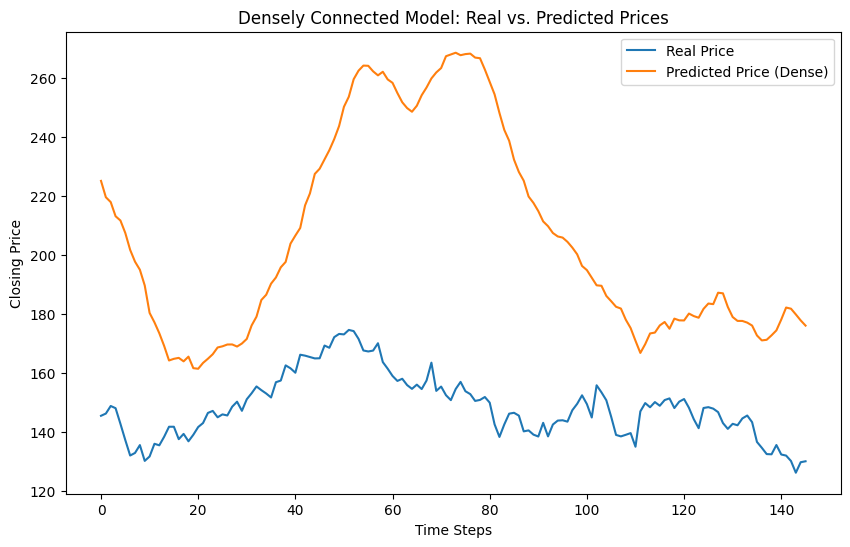

In [9]:
# Gráfico das previsões do modelo Densely Connected vs. Valores Reais
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Real Price')
plt.plot(range(len(y_pred_dense)), y_pred_dense, label='Predicted Price (Dense)')
plt.title('Densely Connected Model: Real vs. Predicted Prices')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [10]:
# Modelo LSTM
inputs = keras.Input(shape=(sequence_length, 1))
x = layers.LSTM(50, activation='relu')(inputs)
outputs = layers.Dense(1)(x)
model_lstm = keras.Model(inputs, outputs)

model_lstm.compile(optimizer='adam', loss='mse')

# Treinamento do modelo LSTM
history_lstm = model_lstm.fit(X_train_scaled.reshape(-1, sequence_length, 1), y_train, epochs=50, batch_size=32, validation_split=0.1)

# Avaliação do modelo LSTM usando MAPE
y_pred_lstm = model_lstm.predict(X_test_scaled.reshape(-1, sequence_length, 1))
mape_lstm = mean_absolute_percentage_error(y_test, y_pred_lstm)
print(f"MAPE LSTM: {mape_lstm:.2f}")



Epoch 1/50
13/13 [==============================] - 2s 36ms/step - loss: 13399.0195 - val_loss: 21521.1406
Epoch 2/50
13/13 [==============================] - 0s 16ms/step - loss: 13270.9766 - val_loss: 21172.5391
Epoch 3/50
13/13 [==============================] - 0s 18ms/step - loss: 13077.4473 - val_loss: 19301.9238
Epoch 4/50
13/13 [==============================] - 0s 17ms/step - loss: 12457.1709 - val_loss: 4518.1973
Epoch 5/50
13/13 [==============================] - 0s 16ms/step - loss: 12032.8008 - val_loss: 15259.6875
Epoch 6/50
13/13 [==============================] - 0s 17ms/step - loss: 11690.9922 - val_loss: 45839.3164
Epoch 7/50
13/13 [==============================] - 0s 17ms/step - loss: 10797.8789 - val_loss: 10421.6455
Epoch 8/50
13/13 [==============================] - 0s 19ms/step - loss: 7133.7686 - val_loss: 38417.4844
Epoch 9/50
13/13 [==============================] - 0s 15ms/step - loss: 2834.8977 - val_loss: 12239.7070
Epoch 10/50
13/13 [=====================

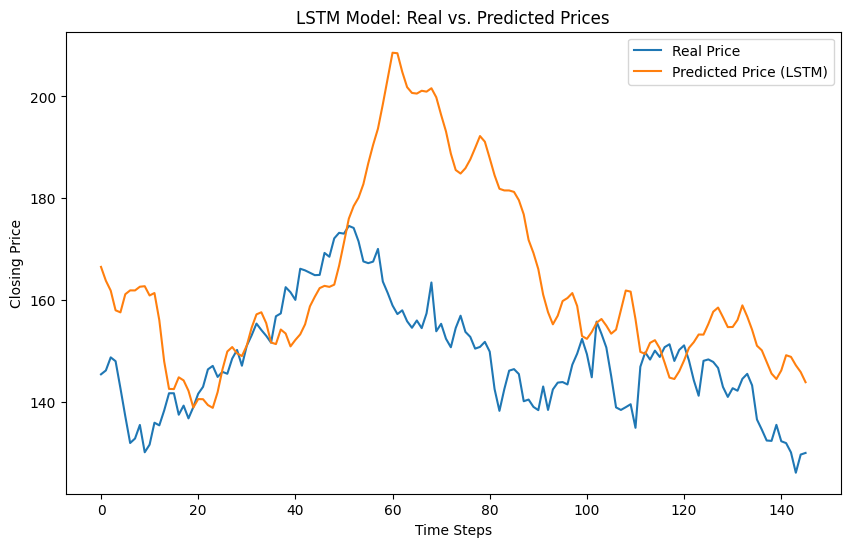

In [11]:
# Gráfico das previsões do modelo LSTM vs. Valores Reais
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Real Price')
plt.plot(range(len(y_pred_lstm)), y_pred_lstm, label='Predicted Price (LSTM)')
plt.title('LSTM Model: Real vs. Predicted Prices')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [12]:
# Modelo LSTM com Regularização de Dropout
inputs = keras.Input(shape=(sequence_length, 1))
x = layers.LSTM(50, dropout=0.2, recurrent_dropout=0.2)(inputs)
outputs = layers.Dense(1)(x)
model_lstm_dropout = keras.Model(inputs, outputs)

model_lstm_dropout.compile(optimizer='adam', loss='mse')

# Treinamento do modelo LSTM com Regularização de Dropout
history_lstm_dropout = model_lstm_dropout.fit(X_train_scaled.reshape(-1, sequence_length, 1), y_train, epochs=50, batch_size=32, validation_split=0.1)

# Avaliação do modelo LSTM com Regularização de Dropout usando MAPE
y_pred_lstm_dropout = model_lstm_dropout.predict(X_test_scaled.reshape(-1, sequence_length, 1))
mape_lstm_dropout = mean_absolute_percentage_error(y_test, y_pred_lstm_dropout)
print(f"MAPE LSTM with Dropout: {mape_lstm_dropout:.2f}")

Epoch 1/50
13/13 [==============================] - 4s 60ms/step - loss: 13391.4932 - val_loss: 21238.4355
Epoch 2/50
13/13 [==============================] - 0s 35ms/step - loss: 13134.4736 - val_loss: 20376.5781
Epoch 3/50
13/13 [==============================] - 0s 35ms/step - loss: 12582.0176 - val_loss: 19809.8184
Epoch 4/50
13/13 [==============================] - 0s 33ms/step - loss: 11948.9248 - val_loss: 19314.0449
Epoch 5/50
13/13 [==============================] - 0s 36ms/step - loss: 11527.7734 - val_loss: 18902.2891
Epoch 6/50
13/13 [==============================] - 0s 33ms/step - loss: 11244.2314 - val_loss: 18565.8848
Epoch 7/50
13/13 [==============================] - 1s 38ms/step - loss: 10996.4375 - val_loss: 18264.0254
Epoch 8/50
13/13 [==============================] - 0s 32ms/step - loss: 10780.8174 - val_loss: 17994.4766
Epoch 9/50
13/13 [==============================] - 0s 36ms/step - loss: 10588.3564 - val_loss: 17747.0996
Epoch 10/50
13/13 [==================

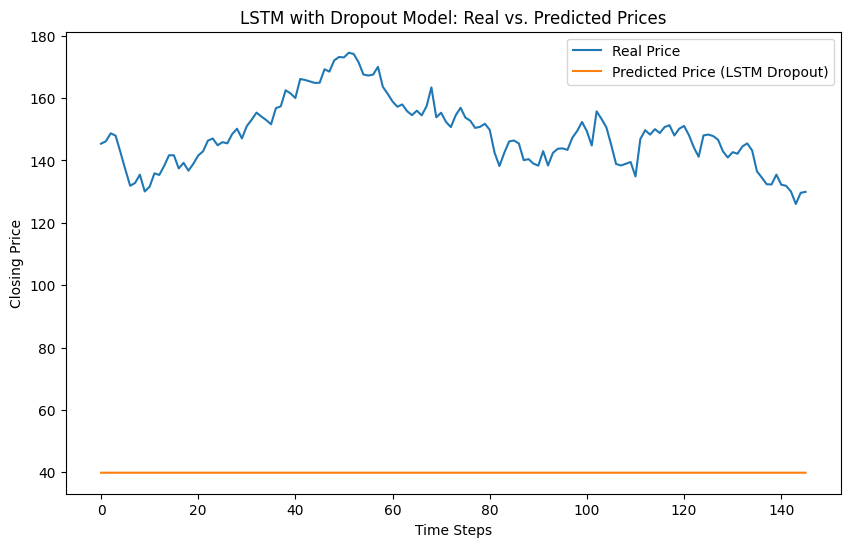

In [13]:
# Gráfico das previsões do modelo LSTM com Regularização de Dropout vs. Valores Reais
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Real Price')
plt.plot(range(len(y_pred_lstm_dropout)), y_pred_lstm_dropout, label='Predicted Price (LSTM Dropout)')
plt.title('LSTM with Dropout Model: Real vs. Predicted Prices')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [14]:
# Modelo Bidirectional LSTM
inputs = keras.Input(shape=(sequence_length, 1))
x = layers.Bidirectional(layers.LSTM(50, activation='relu'))(inputs)
outputs = layers.Dense(1)(x)
model_bidirectional_lstm = keras.Model(inputs, outputs)

model_bidirectional_lstm.compile(optimizer='adam', loss='mse')

# Treinamento do modelo Bidirectional LSTM
history_bidirectional_lstm = model_bidirectional_lstm.fit(X_train_scaled.reshape(-1, sequence_length, 1), y_train, epochs=50, batch_size=32, validation_split=0.1)

# Avaliação do modelo Bidirectional LSTM usando MAPE
y_pred_bidirectional_lstm = model_bidirectional_lstm.predict(X_test_scaled.reshape(-1, sequence_length, 1))
mape_bidirectional_lstm = mean_absolute_percentage_error(y_test, y_pred_bidirectional_lstm)
print(f"MAPE Bidirectional LSTM: {mape_bidirectional_lstm:.2f}")

Epoch 1/50
13/13 [==============================] - 3s 70ms/step - loss: 13388.8682 - val_loss: 21352.2148
Epoch 2/50
13/13 [==============================] - 1s 43ms/step - loss: 13061.9053 - val_loss: 189771.4531
Epoch 3/50
13/13 [==============================] - 1s 43ms/step - loss: 12358.7510 - val_loss: 10729.8438
Epoch 4/50
13/13 [==============================] - 1s 44ms/step - loss: 11576.9678 - val_loss: 4780.9990
Epoch 5/50
13/13 [==============================] - 1s 45ms/step - loss: 10957.6152 - val_loss: 26030.2871
Epoch 6/50
13/13 [==============================] - 1s 40ms/step - loss: 7616.8257 - val_loss: 23515.8379
Epoch 7/50
13/13 [==============================] - 0s 23ms/step - loss: 4725.8643 - val_loss: 5958.5044
Epoch 8/50
13/13 [==============================] - 0s 25ms/step - loss: 2485.1882 - val_loss: 64.0271
Epoch 9/50
13/13 [==============================] - 0s 24ms/step - loss: 698.9133 - val_loss: 52.3220
Epoch 10/50
13/13 [==============================

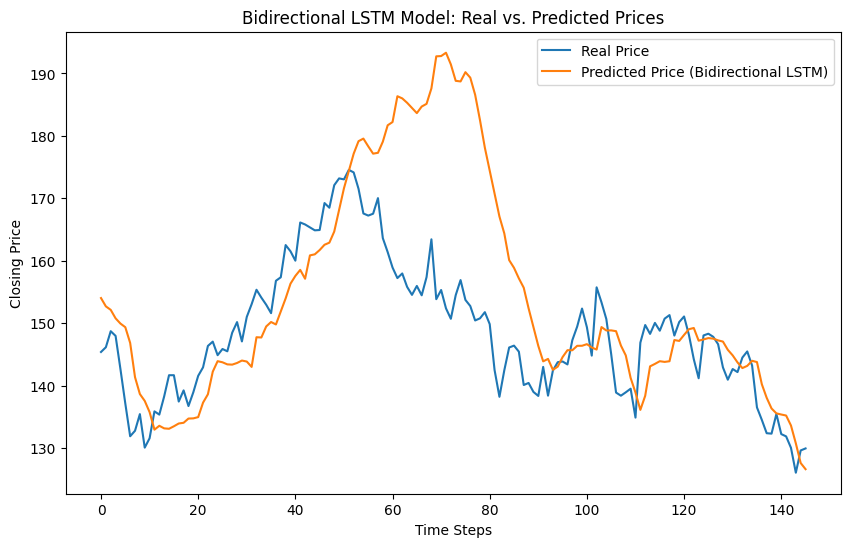

In [15]:
# Gráfico das previsões do modelo Bidirectional LSTM vs. Valores Reais
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Real Price')
plt.plot(range(len(y_pred_bidirectional_lstm)), y_pred_bidirectional_lstm, label='Predicted Price (Bidirectional LSTM)')
plt.title('Bidirectional LSTM Model: Real vs. Predicted Prices')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

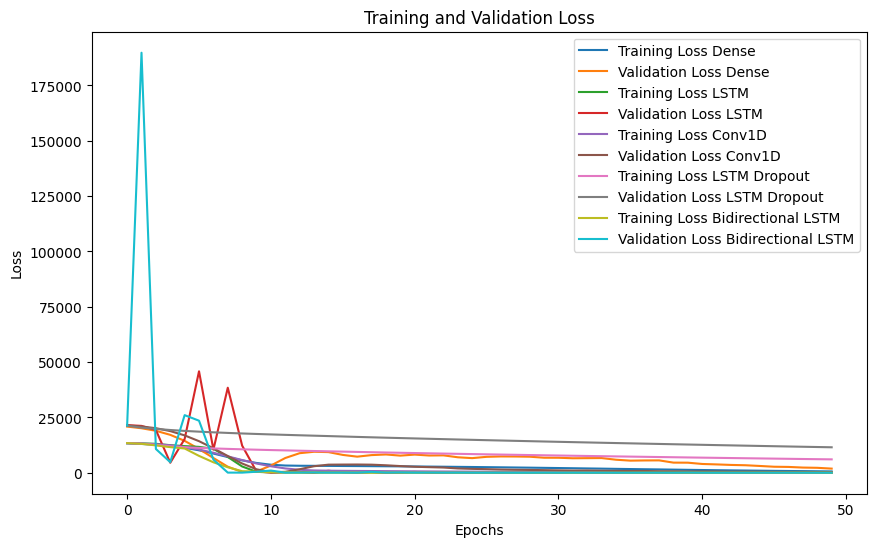

In [16]:
# Visualização da perda durante o treinamento
plt.figure(figsize=(10, 6))
plt.plot(history_dense.history['loss'], label='Training Loss Dense')
plt.plot(history_dense.history['val_loss'], label='Validation Loss Dense')
plt.plot(history_lstm.history['loss'], label='Training Loss LSTM')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss LSTM')
plt.plot(history_conv1d.history['loss'], label='Training Loss Conv1D')
plt.plot(history_conv1d.history['val_loss'], label='Validation Loss Conv1D')
plt.plot(history_lstm_dropout.history['loss'], label='Training Loss LSTM Dropout')
plt.plot(history_lstm_dropout.history['val_loss'], label='Validation Loss LSTM Dropout')
plt.plot(history_bidirectional_lstm.history['loss'], label='Training Loss Bidirectional LSTM')
plt.plot(history_bidirectional_lstm.history['val_loss'], label='Validation Loss Bidirectional LSTM')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()